<a href="https://colab.research.google.com/github/inhan05053/ComputerGraphics/blob/main/13%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.1 MB 5.4 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow import keras


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

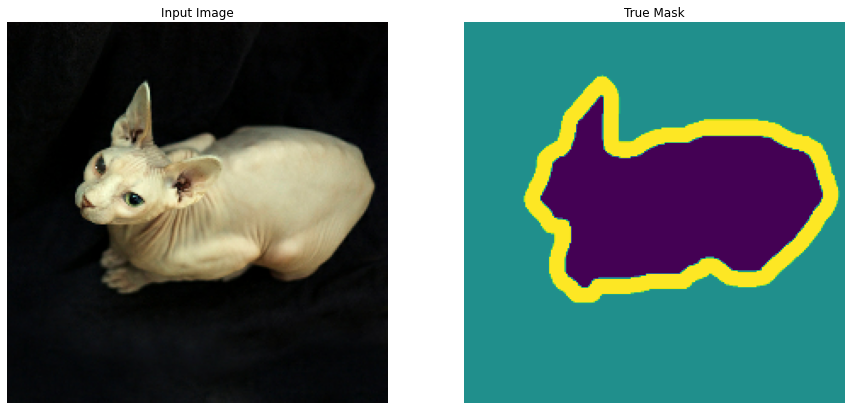

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:

input  = keras.Input(shape=(224, 224,3))

x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(input)
x = keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)

x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x)
x = keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)

x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x)
x = keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x1 = keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)

x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x1)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x2 = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)

x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x2)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)

x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x)
x = keras.layers.Conv2D(4096, 3, padding='same', activation='relu')(x)
x = keras.layers.Conv2D(3, 1, padding='same', activation='relu')(x)


upx = keras.layers.Conv2DTranspose(3,(2,2),(2,2),padding= 'valid', activation = 'relu')(x)
x = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same')(x)
x = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same')(x)

# x = keras.layers.UpSampling2D(size = (2,2), interpolation = 'bilinear' )(x2)
x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x2)
x = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same', activation='relu')(x)
add_x1 = keras.layers.Add()([upx,x])

upx2 = keras.layers.Conv2DTranspose(3,(2,2),(2,2),padding= 'valid', activation = 'relu')(add_x1)
upx2 = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same')(upx2)
upx2 = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same')(upx2)

# x = keras.layers.UpSampling2D(size = (2,2), interpolation = 'bilinear' )(x1)
x = keras.layers.MaxPool2D((3,3), strides=(2,2), padding = 'same')(x1)
x = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same', activation='relu')(x)
add_x2 = keras.layers.Add()([upx2,x])

x = keras.layers.Conv2DTranspose(3,(8,8),(8,8),padding= 'valid', activation = 'relu')(add_x2)
x = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same')(x)
x = keras.layers.Conv2D( 3, (3,3), (1,1), padding='same')(x)

fcn_model = keras.Model(input, x)
fcn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = fcn_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(fcn_model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

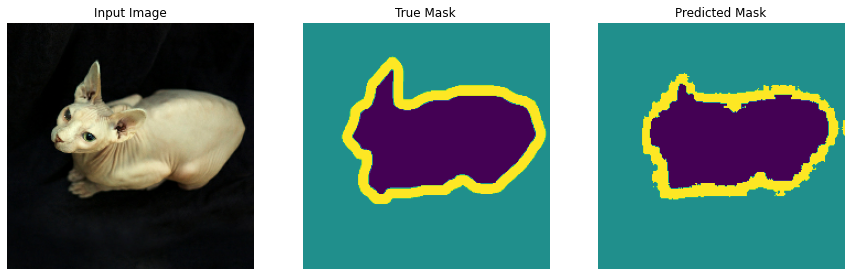


에포크 이후 예측 예시 50

57/57 [==============================] - 71s 1s/step - loss: 0.1866 - val_loss: 0.4351


In [ ]:
fcn_model.compile(optimizer='Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = fcn_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
show_predictions(test_dataset,5)

NameError: ignored